In [76]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, Normalizer, StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, roc_curve
from sklearn.metrics import make_scorer, confusion_matrix
import xgboost as xgb

In [2]:
data_path = os.path.join(os.getcwd(), 'ynap_data')
print(data_path)

/nfs/science/shared/ipythonNotebooks/leom/Kaggle/Ynap-master/ynap_data


In [3]:
print(os.listdir(data_path))

['transactions.csv', 'df_tot_log.csv', '~$sk_overview.docx', 'df_quarterly.csv', 'df_tot_log_noout.csv', 'df_monthly.csv', 'df_quarterly_log.csv', 'account.csv', 'Thumbs.db', 'df_tot.csv', 'df_quarterly_log_noout.csv']


In [4]:
df_tot = pd.read_csv(os.path.join(data_path, 'df_quarterly_log.csv'))
df_tot['var3'] = df_tot['var3'].astype('category')
df_tot['var5'] = df_tot['var5'].astype('category')
df_tot['var6'] = df_tot['var6'].astype('category')

# make dummies out of categorical variables
dummy_idx = np.where(df_tot.dtypes == 'category')[0]
df_dummies = pd.get_dummies(df_tot.iloc[:, dummy_idx])
df = pd.concat([df_tot.drop(df_tot.iloc[:, dummy_idx].columns.values, axis=1), df_dummies], axis=1)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15695 entries, 0 to 15694
Columns: 113 entries, customer_id to var6_1.0
dtypes: float64(103), int64(2), uint8(8)
memory usage: 12.7 MB


## Balance
Let's use the standard transformed data

In [6]:
df_for_model = df

In [7]:
X = df_for_model.drop(['customer_id', 'lapsed_next_period'], axis=1)
y = df_for_model[['customer_id', 'lapsed_next_period']]

print(X.shape)
print(y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

(15695, 111)
(15695, 2)


In [8]:
X_train_1 = X_train.loc[y_train[y_train['lapsed_next_period'] == 1].index]
X_train_0 = X_train.loc[y_train[y_train['lapsed_next_period'] == 0].index]

print(X_train_1.shape)
print(X_train_0.shape)
print(X_train_1.shape[0]/X_train.shape[0])

(657, 111)
(11899, 111)
0.05232558139534884


In [9]:
y_test[y_test['lapsed_next_period'] == 1].shape[0] / y_test.shape[0]

0.052245938196877985

In [10]:
# try different balance ratios with a couple of easy models

def balance_tester(Xtr0, Xtr1, ytr, Xte, yte, zero_quotas = [0.5, 0.66, 0.75], seeds = [21, 2121, 1212], 
                   method='log', method_params=None):
    
    if (method == 'rf') & (method_params == None):
        # Random Forest parameters
        rf_params_bal = {'n_jobs': -1, 'n_estimators': 500, 'warm_start': True, 
                         'max_depth': 4, 'min_samples_leaf': 2, 'max_features' : 'sqrt',
                         'verbose': 0}
    
    results = pd.DataFrame(columns=['quota', 'accuracy', 'pred_perc', 'recall'])
    
    for quota in zero_quotas:
        accuracy = []
        pred_perc = []
        recall = []
        
        n_sample = int(Xtr1.shape[0] * quota / (1 - quota) // 1)
        
        for seed in seeds:
            Xtr0_ = Xtr0.sample(n=n_sample, random_state=seed)
            Xtr_ = Xtr0_.append(Xtr1)
            ytr_ = ytr.loc[Xtr_.index]
            
            if method == 'log':
                clf = LogisticRegression(max_iter=100, solver='liblinear')
            elif method == 'rf':
                clf = RandomForestClassifier(**rf_params_bal)
            else:
                return 'Method not recognized'
            
            clf.fit(Xtr_, ytr_)
            clf_pred = clf.predict(Xte)
            cf = confusion_matrix(yte, clf_pred)
            
            pred_perc.append(clf_pred.sum()/len(clf_pred))
            accuracy.append(accuracy_score(yte, clf_pred))
            recall.append(cf[1, 1] / cf[1, :].sum())
            
            
        # print(np.array(accuracy).mean())
        acc_mean = np.array(accuracy).mean()
        pp_mean = np.array(pred_perc).mean()
        rec_mean = np.array(recall).mean()
        
        results = results.append(pd.Series({'quota': quota, 'accuracy': acc_mean,
                                            'pred_perc': pp_mean, 'recall': rec_mean}),
                                 ignore_index=True)
    
    return results
            
quotas = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.825, 0.85, 0.9]
# quotas = [0.8, 0.805, 0.81, 0.815, 0.82, 0.825, 0.83, 0.835, 0.84, 0.845, 0.85]
balance_res_rf = balance_tester(X_train_0, X_train_1, y_train['lapsed_next_period'], X_test, 
                                y_test['lapsed_next_period'], quotas, method='rf')

balance_res_log = balance_tester(X_train_0, X_train_1, y_train['lapsed_next_period'], X_test, 
                                y_test['lapsed_next_period'], quotas, method='log')

In [11]:
balance_res_log['acc_recall'] = 0.4 * balance_res_log['accuracy'] + 0.6 * balance_res_log['recall']
balance_res_log

,quota,accuracy,pred_perc,recall,acc_recall
0,0.500,0.738027,0.289795,0.766260,0.754967
1,0.550,0.761389,0.262398,0.727642,0.741141
2,0.600,0.783158,0.235744,0.680894,0.721800
3,0.650,0.810024,0.205267,0.646341,0.711815
4,0.700,0.834342,0.175003,0.589431,0.687395
5,0.750,0.860359,0.141128,0.514228,0.652680
6,0.800,0.892641,0.097802,0.408537,0.602178
7,0.825,0.904641,0.077944,0.333333,0.561856
8,0.850,0.918339,0.056600,0.260163,0.523433
9,0.900,0.945312,0.010725,0.079268,0.425686


In [12]:
balance_res_rf['acc_recall'] = 0.4 * balance_res_rf['accuracy'] + 0.6 * balance_res_rf['recall']
balance_res_rf

,quota,accuracy,pred_perc,recall,acc_recall
0,0.500,0.741637,0.287034,0.774390,0.761289
1,0.550,0.768398,0.258363,0.756098,0.761018
2,0.600,0.792609,0.228629,0.703252,0.738995
3,0.650,0.810980,0.204099,0.644309,0.710977
4,0.700,0.834555,0.173516,0.577236,0.680163
5,0.750,0.872996,0.127004,0.500000,0.649198
6,0.800,0.908463,0.074121,0.333333,0.563385
7,0.825,0.923012,0.052565,0.266260,0.528961
8,0.850,0.940533,0.021451,0.136179,0.457921
9,0.900,0.947754,0.000000,0.000000,0.379102


In [13]:
quota = 0.5
n_sample = int(X_train_1.shape[0] * quota / (1 - quota) // 1)
X_train_0_ = X_train_0.sample(n=n_sample, random_state=101)

X_train_ = X_train_0_.append(X_train_1)
print(X_train_.shape)

y_train_ = y_train.loc[X_train_.index]
print(y_train_.shape)

df_ = y_train_.join(X_train_)
y_corr = df_.drop('customer_id', axis=1).corr().loc['lapsed_next_period']

(1314, 111)
(1314, 2)


In [17]:
model_cols = list(X_train_.columns.values)
print(len(model_cols))

111


In [18]:
# Logistic Regression for feature selection
log_test = LogisticRegression()
log_test = log_test.fit(X_train_[model_cols], y_train_['lapsed_next_period'])
score_log = log_test.score(X_train_[model_cols], y_train_['lapsed_next_period'])
print(score_log)

0.813546423135


In [22]:
log_features = pd.DataFrame(list(zip(X_train_[model_cols].columns, np.transpose(log_test.coef_))))
log_features[(log_features[1] >= -0.05) & (log_features[1] <= 0.05)].sort_values(1, ascending=True)

,0,1
21,designer_id_199001,[-0.042443852264]
109,var6_0.0,[-0.0313401808797]
49,quote_spend_returned_198903,[-0.0285207893645]
73,ns_per_order_199002,[-0.00614289267061]
56,quote_var1_198904,[-0.00226383272152]
57,quote_var1_199001,[-0.00211981921744]
17,product_type_id_199003,[-0.00209852694281]
36,net_spend_199004,[-1.53540004965e-05]
0,var4,[0.00385901597282]
59,quote_var1_199003,[0.0049926329919]


In [26]:
weak_predictors = list(log_features[(log_features[1] >= -0.05) & (log_features[1] <= 0.05)][0])
weak_predictors.remove('var6_0.0') # I can't remove this without the other categories of the variable
print(weak_predictors)

['var4', 'order_id_199003', 'product_type_id_199003', 'designer_id_199001', 'net_spend_199004', 'quote_spend_returned_198903', 'quote_var1_198904', 'quote_var1_199001', 'quote_var1_199002', 'quote_var1_199003', 'quote_var2_198903', 'quote_var2_199001', 'ns_per_order_199002', 'gs_per_order_199003', 'ir_per_order_199001']


In [29]:
model_cols2 = [x for x in model_cols if x not in weak_predictors]
print(len(model_cols2))

96


In [31]:
# REPEAT Logistic Regression for feature selection
log_test = LogisticRegression()
log_test = log_test.fit(X_train_[model_cols2], y_train_['lapsed_next_period'])
score_log = log_test.score(X_train_[model_cols2], y_train_['lapsed_next_period'])
print(score_log)

0.815068493151


In [32]:
log_features2 = pd.DataFrame(list(zip(X_train_[model_cols2].columns, np.transpose(log_test.coef_))))
log_features2[(log_features2[1] >= -0.05) & (log_features2[1] <= 0.05)].sort_values(1, ascending=True)

,0,1
94,var6_0.0,[-0.039583838879]
72,gs_per_order_198903,[0.0473107561929]


In [35]:
# Random Forest example
rf_params = {
    'n_jobs': -1,
    'n_estimators': 200,
     'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 4,
    'min_samples_leaf': 4,
    'max_features' : 'sqrt',
    'verbose': 0
}

rf = RandomForestClassifier(**rf_params)
rf.fit(X_train_[model_cols2], y_train_['lapsed_next_period'])

rf_pred = rf.predict(X_test[model_cols2])

print(rf_pred.sum()/len(rf_pred))

print(accuracy_score(y_test['lapsed_next_period'], rf_pred))

0.28384835935
0.744823192099


In [36]:
cf = confusion_matrix(y_test['lapsed_next_period'], rf_pred)
cf[1,1]/cf[1,:].sum()

0.77439024390243905

In [51]:
def right_classification(y_true, y_pred):
    cf = confusion_matrix(y_true, y_pred)
    return cf[1, 1] / cf[1, :].sum()

In [52]:
# Setting multiple hyperparameters for every classifier we are going to implement

# Random Forest
rf_params_gs = {
    'n_jobs': [-1],
    'n_estimators': [100, 125, 150, 175, 200], #, 250, 300, 350, 400, 500],
    'warm_start': [True], 
     #'max_features': 0.2,
    'max_depth': [4, 5, 6],
    'min_samples_leaf': [4, 5, 6], #[2, 3]
    'max_features' : ['sqrt'],
    'verbose': [0]
}

# Extra Trees
et_params_gs = {
    'n_jobs': [-1],
    'n_estimators': [600, 650, 700, 800],
    'max_depth': [3, 4, 5, 6],
    'min_samples_leaf': [2, 3, 4],
    'verbose': [0]
}

# AdaBoost parameters
ada_params_gs = {
    'n_estimators': [100, 125, 150, 175, 200],
    'learning_rate': [0.03, 0.05, 0.07]
}

# Gradient Boosting parameters
gb_params_gs = {
    'n_estimators': [100, 125, 150, 175], # 200, 250, 300],
    'max_depth': [2, 3, 4, 5],
    'min_samples_leaf': [4, 5, 6],
    'verbose': [0]
}

# SVC parameters
svc_params_gs = {
    'kernel': ['linear', 'rbf'],
    'C': [1e-5, 5e-5, 1e-4, 5e-4], #1e-3, 0.01, 0.05]
}

# Logistic regression parameters
log_params_gs = {
    'solver': ['liblinear'],
    'max_iter': [100, 200, 300],
    'verbose': [0]
}

# XGBoosting parameters
xgb_params_gs = {
    'objective':['binary:logistic'],
    'learning_rate': [5e-4, 1e-3, 2e-3], #0.01], #so called `eta` value
    'max_depth': [2, 3, 4], #5, 6],
    'min_child_weight': [11],
    'silent': [1],
    'subsample': [0.8],
    'colsample_bytree': [0.7],
    'n_estimators': [300, 400, 500], #number of trees, change it to 1000 for better results
    'missing':[-999]
}

In [53]:
scoring = {'right_class': make_scorer(right_classification)}

In [54]:
# Istantiate the classifiers
rf = GridSearchCV(RandomForestClassifier(), rf_params_gs, cv=5, scoring=scoring, refit='right_class')
et = GridSearchCV(ExtraTreesClassifier(), et_params_gs, cv=5, scoring=scoring, refit='right_class')
ada = GridSearchCV(AdaBoostClassifier(), ada_params_gs, cv=5, scoring=scoring, refit='right_class')
gb = GridSearchCV(GradientBoostingClassifier(), gb_params_gs, cv=5, scoring=scoring, refit='right_class')
svc = GridSearchCV(SVC(), svc_params_gs, cv=5, scoring=scoring, refit='right_class')
log = GridSearchCV(LogisticRegression(), log_params_gs, cv=5, scoring=scoring, refit='right_class')
xgbm = GridSearchCV(xgb.XGBClassifier(), xgb_params_gs, cv=5, scoring=scoring, refit='right_class')

In [55]:
def classifier_runner(clf, Xtr, ytr, Xte, yte):
    print('-'*40)
    print(clf.estimator)
    print('-'*40)
    clf.fit(Xtr, ytr)
    clf.best_params_
    print(clf.best_params_)
    
    print()
    
#     means = clf.cv_results_['mean_test_score']
#     stds = clf.cv_results_['std_test_score']
#     for mean, std, params in zip(means, stds, clf.cv_results_['params']):
#         print("%0.3f (+/-%0.03f) for %r" % (mean, std*2, params))
        
    print()
    y_true, y_pred = yte, clf.predict(Xte)
    print(classification_report(y_true, y_pred))
    print(accuracy_score(y_true, y_pred))
    print(confusion_matrix(y_true, y_pred))
    print(right_classification(y_true, y_pred))
    
    return clf, y_pred

In [56]:
model_cols = model_cols2

In [57]:
rf_clf, rf_ypred = classifier_runner(rf, X_train_[model_cols], y_train_['lapsed_next_period'],
                                      X_test[model_cols], y_test['lapsed_next_period'])

----------------------------------------
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
----------------------------------------
{'max_depth': 5, 'min_samples_leaf': 5, 'warm_start': True, 'n_jobs': -1, 'n_estimators': 125, 'max_features': 'sqrt', 'verbose': 0}


             precision    recall  f1-score   support

          0       0.98      0.74      0.85      2975
          1       0.14      0.77      0.24       164

avg / total       0.94      0.75      0.82      3139

0.745778910481
[[2214  761]
 [  37  127]]
0.774390243902


In [58]:
et_clf, et_ypred = classifier_runner(et, X_train_[model_cols], y_train_['lapsed_next_period'],
                                      X_test[model_cols], y_test['lapsed_next_period'])

----------------------------------------
ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
----------------------------------------
{'max_depth': 3, 'min_samples_leaf': 4, 'n_jobs': -1, 'verbose': 0, 'n_estimators': 600}


             precision    recall  f1-score   support

          0       0.98      0.73      0.84      2975
          1       0.14      0.78      0.23       164

avg / total       0.94      0.73      0.81      3139

0.731124561962
[[2167  808]
 [  36  128]]
0.780487804878


In [59]:
ada_clf, ada_ypred = classifier_runner(ada, X_train_[model_cols], y_train_['lapsed_next_period'],
                                        X_test[model_cols], y_test['lapsed_next_period'])

----------------------------------------
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)
----------------------------------------
{'learning_rate': 0.05, 'n_estimators': 100}


             precision    recall  f1-score   support

          0       0.98      0.74      0.85      2975
          1       0.14      0.78      0.24       164

avg / total       0.94      0.74      0.81      3139

0.744504619306
[[2209  766]
 [  36  128]]
0.780487804878


In [60]:
gb_clf, gb_ypred = classifier_runner(gb, X_train_, y_train_['lapsed_next_period'], X_test, y_test['lapsed_next_period'])

----------------------------------------
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)
----------------------------------------
{'max_depth': 2, 'min_samples_leaf': 6, 'verbose': 0, 'n_estimators': 100}


             precision    recall  f1-score   support

          0       0.98      0.73      0.84      2975
          1       0.14      0.79      0.24       164

avg / total       0.94      0.73      0.81      3139

0.733035998726
[[2171  804]
 [  34  130]]
0.792682926829


In [61]:
svc_clf, svc_ypred = classifier_runner(svc, X_train_, y_train_['lapsed_next_period'], X_test, y_test['lapsed_next_period'])

----------------------------------------
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
----------------------------------------
{'kernel': 'linear', 'C': 1e-05}


             precision    recall  f1-score   support

          0       0.99      0.26      0.41      2975
          1       0.07      0.96      0.12       164

avg / total       0.94      0.29      0.39      3139

0.294042688754
[[ 765 2210]
 [   6  158]]
0.963414634146


In [85]:
print('svc ' + str(0.294042688754 * 0.4 + 0.963414634146 * 0.6))
print('et ' + str(0.733035998726 * 0.4 + 0.792682926829 * 0.6))

svc 0.6956658559892
et 0.7688241555877999


In [62]:
log_clf, log_ypred =classifier_runner(log, X_train_[model_cols], y_train_['lapsed_next_period'],
                                      X_test[model_cols], y_test['lapsed_next_period'])

----------------------------------------
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
----------------------------------------
{'solver': 'liblinear', 'max_iter': 100, 'verbose': 0}


             precision    recall  f1-score   support

          0       0.98      0.74      0.84      2975
          1       0.13      0.72      0.22       164

avg / total       0.94      0.74      0.81      3139

0.738770309016
[[2201  774]
 [  46  118]]
0.719512195122


In [63]:
xgbm_clf, xgbm_ypred = classifier_runner(xgbm, X_train_[model_cols], y_train_['lapsed_next_period'],
                                         X_test[model_cols], y_test['lapsed_next_period'])

----------------------------------------
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)
----------------------------------------
{'max_depth': 2, 'min_child_weight': 11, 'objective': 'binary:logistic', 'silent': 1, 'learning_rate': 0.002, 'n_estimators': 400, 'subsample': 0.8, 'missing': -999, 'colsample_bytree': 0.7}


             precision    recall  f1-score   support

          0       0.98      0.73      0.84      2975
          1       0.14      0.77      0.23       164

avg / total       0.94      0.73      0.81      3139

0.733673144313
[[2176  799]
 [  37  127]]
0.774390243902


### Feature importances

In [68]:
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
rf_best = SklearnHelper(clf=RandomForestClassifier, params=rf_clf.best_params_)
et_best = SklearnHelper(clf=ExtraTreesClassifier, params=et_clf.best_params_)
ada_best = SklearnHelper(clf=AdaBoostClassifier, params=ada_clf.best_params_)
gb_best = SklearnHelper(clf=GradientBoostingClassifier, params=gb_clf.best_params_)
svc_best = SklearnHelper(clf=SVC, params=svc_clf.best_params_)
log_best = SklearnHelper(clf=LogisticRegression, params=log_clf.best_params_)
xgbm_best = SklearnHelper(clf=xgb.XGBClassifier, params=xgbm_clf.best_params_)

In [69]:
rf_best = rf_best.fit(X_train_[model_cols], y_train_['lapsed_next_period'])
et_best = et_best.fit(X_train_[model_cols], y_train_['lapsed_next_period'])
ada_best = ada_best.fit(X_train_[model_cols], y_train_['lapsed_next_period'])
gb_best = gb_best.fit(X_train_[model_cols], y_train_['lapsed_next_period'])
svc_best = svc_best.fit(X_train_[model_cols], y_train_['lapsed_next_period'])
log_best = log_best.fit(X_train_[model_cols], y_train_['lapsed_next_period'])
xgbm_best = xgbm_best.fit(X_train_[model_cols], y_train_['lapsed_next_period'])

In [70]:
rf_best_score = right_classification(y_pred=rf_best.predict(X_train_[model_cols]),
                                     y_true=y_train_['lapsed_next_period'])
et_best_score = right_classification(y_pred=et_best.predict(X_train_[model_cols]),
                                     y_true=y_train_['lapsed_next_period'])
ada_best_score = right_classification(y_pred=ada_best.predict(X_train_[model_cols]),
                                     y_true=y_train_['lapsed_next_period'])
gb_best_score = right_classification(y_pred=gb_best.predict(X_train_[model_cols]),
                                     y_true=y_train_['lapsed_next_period'])
svc_best_score = right_classification(y_pred=svc_best.predict(X_train_[model_cols]),
                                     y_true=y_train_['lapsed_next_period'])
log_best_score = right_classification(y_pred=log_best.predict(X_train_[model_cols]),
                                     y_true=y_train_['lapsed_next_period'])
xgbm_best_score = right_classification(y_pred=xgbm_best.predict(X_train_[model_cols]),
                                     y_true=y_train_['lapsed_next_period'])

In [71]:
rf_best_score_test = right_classification(y_pred=rf_best.predict(X_test[model_cols]),
                                     y_true=y_test['lapsed_next_period'])
et_best_score_test = right_classification(y_pred=et_best.predict(X_test[model_cols]),
                                     y_true=y_test['lapsed_next_period'])
ada_best_score_test = right_classification(y_pred=ada_best.predict(X_test[model_cols]),
                                     y_true=y_test['lapsed_next_period'])
gb_best_score_test = right_classification(y_pred=gb_best.predict(X_test[model_cols]),
                                     y_true=y_test['lapsed_next_period'])
svc_best_score_test = right_classification(y_pred=svc_best.predict(X_test[model_cols]),
                                     y_true=y_test['lapsed_next_period'])
log_best_score_test = right_classification(y_pred=log_best.predict(X_test[model_cols]),
                                     y_true=y_test['lapsed_next_period'])
xgbm_best_score_test = right_classification(y_pred=xgbm_best.predict(X_test[model_cols]),
                                     y_true=y_test['lapsed_next_period'])

In [72]:
models = pd.DataFrame({
    'Model': ['Random Forests', 'Extratrees', 'AdaBoosting', 
              'Gradient Boosting', 'Support Vector Machine', 
              'Logistic Regression','XGBoost'],
    'Score on training': [rf_best_score, et_best_score, ada_best_score, gb_best_score, 
              svc_best_score, log_best_score, xgbm_best_score],
    'Score on test': [rf_best_score_test, et_best_score_test, ada_best_score_test, gb_best_score_test, 
              svc_best_score_test, log_best_score_test, xgbm_best_score_test]})
models.sort_values(by='Score on training', ascending=False)

,Model,Score on test,Score on training
4,Support Vector Machine,0.975610,0.990868
3,Gradient Boosting,0.798780,0.902588
0,Random Forests,0.780488,0.875190
5,Logistic Regression,0.719512,0.859970
1,Extratrees,0.768293,0.844749
6,XGBoost,0.774390,0.843227
2,AdaBoosting,0.780488,0.838661


In [73]:
summary = pd.DataFrame(list(zip(X_train_[model_cols].columns,
    np.transpose(rf_best.feature_importances_),
    np.transpose(et_best.feature_importances_),
    np.transpose(ada_best.feature_importances_),
    np.transpose(gb_best.feature_importances_),
    np.transpose(xgbm_best.feature_importances_),
    )), columns=['Feature','RF','Extra','Ada','GB','XGB'])
  
summary['Median'] = summary.median(1)
summary.sort_values('Median', ascending=False)

,Feature,RF,Extra,Ada,GB,XGB,Median
4,order_id_199004,0.087924,0.056460,0.21,0.054518,0.101667,0.087924
20,designer_id_199004,0.096264,0.076295,0.05,0.052981,0.139167,0.076295
60,gs_per_item_199004,0.027530,0.020287,0.09,0.061681,0.082500,0.061681
10,product_id_199004,0.057834,0.053766,0.07,0.043109,0.061667,0.057834
26,gross_spend_199004,0.083987,0.047750,0.01,0.025599,0.076667,0.047750
56,gs_per_order_199004,0.053241,0.025326,0.04,0.017618,0.087500,0.040000
14,product_type_id_199002,0.014930,0.032374,0.08,0.021781,0.093333,0.032374
55,ns_per_order_199004,0.030692,0.017286,0.01,0.036748,0.032500,0.030692
15,product_type_id_199004,0.040313,0.080517,0.00,0.000000,0.028333,0.028333
59,ns_per_ib_199004,0.028253,0.011941,0.03,0.056729,0.001667,0.028253


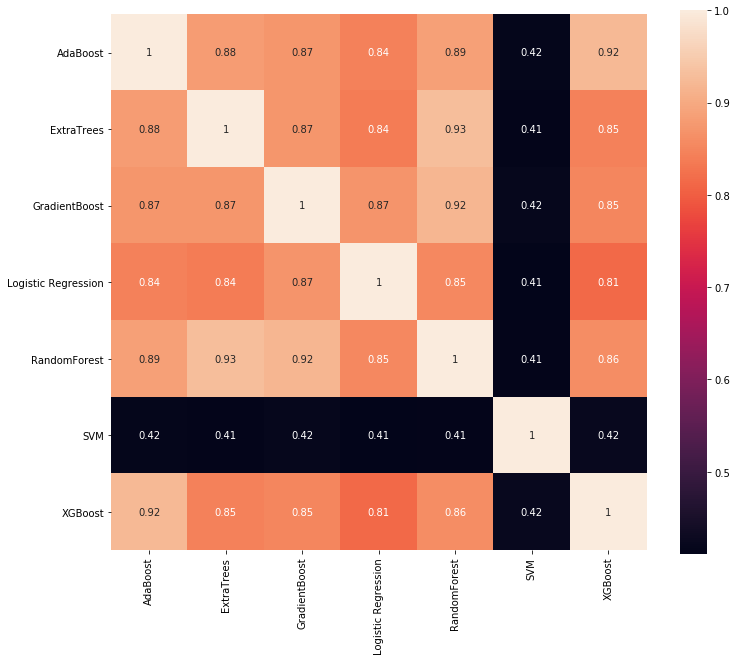

In [74]:
# correlation between model predictions on training data
base_predictions_train = pd.DataFrame( {'RandomForest': rf_best.predict(X_train_[model_cols]),
     'ExtraTrees': et_best.predict(X_train_[model_cols]),
     'AdaBoost': ada_best.predict(X_train_[model_cols]),
     'SVM' : svc_best.predict(X_train_[model_cols]),
     'GradientBoost': gb_best.predict(X_train_[model_cols]),
     'Logistic Regression': log_best.predict(X_train_[model_cols]),
     'XGBoost': xgbm_best.predict(X_train_[model_cols])
    })

plt.figure(figsize=(12,10))
foo = sns.heatmap(base_predictions_train.corr(), vmax=1.0, square=True, annot=True)

In [78]:
# Voting classifier
clf_vote = VotingClassifier(
    estimators=[
        #('tree', clf_tree),
        ('rf', rf_best),
        ('et', et_best),
        ('ada', ada_best),
        ('gb', gb_best),
        ('xgb', xgbm_best),
        ('svm', svc_best),
        ('logistic', log_best)
        ],
    weights=[2,1,1,2,1,3,1],
    voting='hard')
clf_vote.fit(X_train_[model_cols], y_train_['lapsed_next_period'])

VotingClassifier(estimators=[('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weigh...nalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))],
         flatten_transform=None, n_jobs=1, voting='hard',
         weights=[2, 1, 1, 2, 1, 3, 1])

In [79]:
clf_vote_score_train = right_classification(y_pred=clf_vote.predict(X_train_[model_cols]),
                                     y_true=y_train_['lapsed_next_period'])
clf_vote_score_train

0.8995433789954338

In [80]:
clf_vote_score_test = right_classification(y_pred=clf_vote.predict(X_test[model_cols]),
                                     y_true=y_test['lapsed_next_period'])
clf_vote_score_test

0.81707317073170727

In [81]:
print(confusion_matrix(y_test['lapsed_next_period'], clf_vote.predict(X_test[model_cols])))

[[2114  861]
 [  30  134]]


In [82]:
print(confusion_matrix(y_test['lapsed_next_period'], svc_best.predict(X_test[model_cols])))

[[ 776 2199]
 [   4  160]]
